In [328]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import accuracy_score
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [329]:
data_train = pd.read_csv('/kaggle/input/titanic/train.csv')
data_test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [330]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [331]:
data_train.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [332]:
data_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Удалим эти признаки, т.к. они не несут полезной информации

In [333]:
data_train = data_train.drop(['Cabin', 'Name','Ticket'], axis = 1)
data_test = data_test.drop(['Cabin', 'Name','Ticket'], axis = 1)

Заполним пропуски числовых признаков медианным значением каждого столбца, поскольку медиана более устойчива к выбросам.

In [334]:
data_train['Age'] = data_train['Age'].fillna(data_train['Age'].median())
data_test['Age'] = data_test['Age'].fillna(data_train['Age'].median())
data_test['Fare'] = data_test['Fare'].fillna(data_train['Age'].median())

Пропущенные значения признака Embarked заполним самым популярным значением.

In [335]:
data_train['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [336]:
data_train['Embarked'] = data_train['Embarked'].fillna('S')
data_test['Embarked'] = data_test['Embarked'].fillna('S')

In [337]:
data_train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [338]:
data_test.isna().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [339]:
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


Закодируем категориальные признаки при помощи Label Encoding.

In [340]:
enc = LabelEncoder()
data_train['Embarked'] = enc.fit_transform(data_train['Embarked'])
data_train['Sex'] = enc.fit_transform(data_train['Sex'])

data_test['Embarked'] = enc.fit_transform(data_test['Embarked'])
data_test['Sex'] = enc.fit_transform(data_test['Sex'])

Нормируем цену на билет

In [341]:
scaler = StandardScaler()
data_train['Fare'] = scaler.fit_transform(data_train['Fare'].values.reshape([-1,1]))

data_test['Fare'] = scaler.fit_transform(data_test['Fare'].values.reshape([-1,1]))


Оценим зависимость таргета от признаков через матрицу корреляции.

<Axes: >

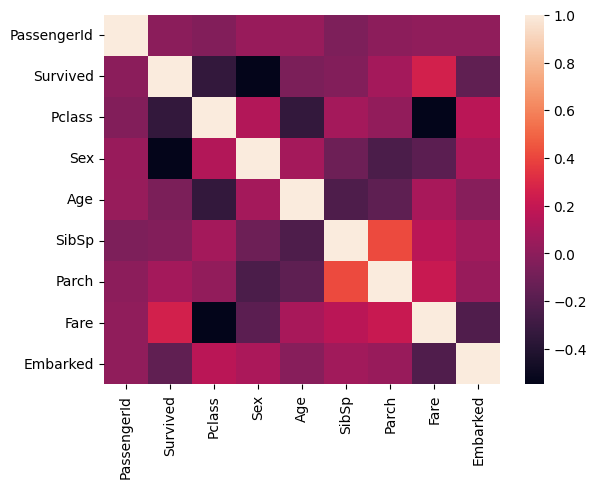

In [342]:
sns.heatmap(data_train.corr())

Разделим выборку на тестовую и тренировочную и выберем лучшую модель.

In [343]:
y = data_train['Survived']
X = data_train.drop('Survived', axis = 1)
X.isna().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [344]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [345]:
log = LogisticRegression(solver='liblinear', random_state=42)
log.fit(X_train, y_train)
pred_lr = log.predict(X_test)
accuracy_score(pred_lr, y_test)


0.7947761194029851

In [346]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
accuracy_score(pred_rf, y_test)

0.8171641791044776

In [347]:
SGD = SGDClassifier(random_state=42)
SGD.fit(X_train, y_train)
pred_SGD = SGD.predict(X_test)

accuracy_score(pred_SGD, y_test)

0.585820895522388

In [348]:
r = RidgeClassifier(random_state=42)
r.fit(X_train, y_train)
pred_r = r.predict(X_test)

accuracy_score(pred_r, y_test)

0.7947761194029851

RandomForest в данном случае показал наибольший процент правильных ответов.

Обучаем финальную модель

In [349]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
pred = rf.predict(data_test)


In [350]:
output = pd.DataFrame({'PassengerId': data_test.PassengerId, 'Survived': pred})
output.to_csv('submission_rf.csv', index=False)
print("Saved")

Saved


Score 0.78708
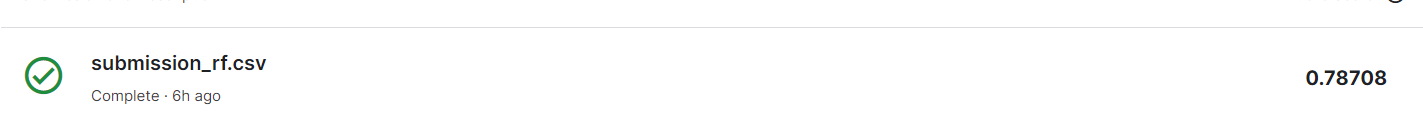